In [1]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution, OptimizationBehavior
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from joblib.parallel import Parallel, delayed
import pickle


In [2]:
from multiprocessing import cpu_count
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 20


In [3]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [4]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
        self.memory += other.memory
        return self

    def __add__(self, other):
        self.memory = self.memory + other.memory
        return self

In [5]:
frames = []

def fitness_function_pt(
    multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False
):
    memory = ReplayMemory(10000)
    rewards = []

    for _ in range(num_episodes):
        # get initial state of the environment
        observation = env.reset()
        observation = observation[0]

        for _ in range(episode_duration):
            if render:
                frames.append(env.render())

            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()

            # what goes here? TODO
            action = torch.argmax(multitree.get_output_pt(input_sample))
            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards.append(reward)
            output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            memory.push(
                input_sample,
                torch.tensor([[action.item()]]),
                output_sample,
                torch.tensor([reward]),
            )
            if (terminated or truncated) and not ignore_done:
                break

    fitness = np.sum(rewards)

    return fitness, memory

## Self adaptation in coefficient mutation

adding an additional parameter $\sigma$ is added to the constant node.  

$\sigma = \max\left(\exp(N(0,\gamma^2)), \epsilon\right)$

$c' = N(c, \sigma^2)$

$\sigma ' = \max(\sigma \exp(N(0,\gamma^2)), \epsilon)$

In [6]:
from genepro.multitree import Multitree
import numpy as np


class AdaptiveConstant(Constant):
    def __init__(self, value: float = None):
        super().__init__(value)
        # self.gamma = gamma
        # self.epsilon = epsilon
        self.sigma = (
            1.0  # np.max([np.exp(self.gamma * np.random.randn()), self.epsilon])
        )

    def set_sigma(self, sigma):
        self.sigma = sigma


def coeff_adaptive_mutation(
    multitree: Multitree,
    prob_coeff_mut: float = 0.25,
    gamma: float = 0.1,
    epsilon: float = 1e-16,
) -> Node:
    """
    Applies random coefficient mutations to constant nodes

    Parameters
    ----------
    tree : Node
      the tree to which coefficient mutations are applied
    prob_coeff_mut : float, optional
      the probability with which coefficients are mutated (default is 0.25)
    temp : float, optional
      "temperature" that indicates the strength of coefficient mutation, it is relative to the current value (i.e., v' = v + temp*abs(v)*N(0,1))

    Returns
    -------
    Node
      the tree after coefficient mutation (it is the same as the tree in input)
    """
    r = np.random.randint(multitree.n_trees)
    tree = multitree.children[r]
    coeffs = [n for n in tree.get_subtree() if type(n) == Constant]
    for c in coeffs:
        # decide wheter it should be applied
        if np.random.uniform() < prob_coeff_mut:
            v = c.get_value()
            # update the value by +- sigma*N(0,1)
            new_sigma = np.max([c.sigma * np.exp(gamma * np.random.randn()), epsilon])
            c.set_sigma(new_sigma)

            new_v = v + c.sigma * np.random.randn()

            c.set_value(new_v)

    multitree.children[r] = tree
    return multitree

In [7]:
# import numpy as np
from copy import deepcopy
from joblib.parallel import Parallel, delayed
import itertools



def paralel_tournament_selection(contestants : list, num_to_select : int, tournament_size : int=4) -> list:
  """
  Performs tournament selection on the contestants until the given number of selected contestants is reached;
  note that `len(contestants)` needs to be a multiple of `tournament_size` and similarly for `num_to_select`

  Parameters
  ----------
  contestants : list
    list of Node containing trees that undergo the selection
  num_survivors : int
    how many should be selected
  tournament_size : int, optional
    the size (window) of tournament selection (default is 4)

  Returns
  -------
  list
    list containing (copies of) the trees that were selected
  """
  selected = list()

  n = len(contestants)
  num_selected_per_parse = n // tournament_size
  num_parses = num_to_select // num_selected_per_parse

  # assert quantities are compatible
  assert n / tournament_size == num_selected_per_parse, "Number of contestants {} is not a multiple of tournament size {}".format(n,tournament_size)
  assert num_to_select / num_selected_per_parse == num_parses
 
  def tournament():
    # shuffle
    temp = np.random.permutation(contestants)
    fitnesses = np.array([t.fitness for t in temp])

    winning_indices = np.argmax(fitnesses.reshape((-1, tournament_size)), axis=1)
    winning_indices += np.arange(0, n, tournament_size)

    return [deepcopy(temp[i]) for i in winning_indices]
  
  selected = Parallel(n_jobs=20)(delayed(tournament)() for _ in range(num_parses))
#   for _ in range(num_parses):
#     # shuffle
#     np.random.shuffle(contestants)
#     fitnesses = np.array([t.fitness for t in contestants])

#     winning_indices = np.argmax(fitnesses.reshape((-1, tournament_size)), axis=1)
#     winning_indices += np.arange(0, n, tournament_size)

#     selected += [deepcopy(contestants[i]) for i in winning_indices]
  selected = list(itertools.chain.from_iterable(selected))
  # print(selected)
  return selected
 

In [8]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [
    AdaptiveConstant()
]  # Think about the probability of sampling a coefficient
internal_nodes = [
    Plus(),
    Minus(),
    Times(),
    Div(),
    Square(),
    Sqrt(),
]  # Add your own operators here


evo_adaptive = Evolution(
    fitness_function_pt,
    internal_nodes,
    leaf_nodes,
    4,
    pop_size=64,
    max_gens=5,
    max_tree_size=40,
    coeff_opts=[
        {
            "fun": coeff_adaptive_mutation,
            "rate": 0.3, # rate of applying the mutation to the variation
            "prob": 1, # probability of applying the mutation to the coefficient
            "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
            "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
        }
    ],
    # selection={"fun":paralel_tournament_selection},
    n_jobs=n_cores,
    verbose=True,
)

# evo_adaptive.evolve()

In [9]:
def get_test_score(tree, env):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness
# frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)



### Setup experiment for self adaptive mutation

run 7 test and one with the normal setup 

In [10]:
# best = evo_adaptive.best_of_gens[-1]

# print(best.get_readable_repr())
# print(get_test_score(best))

# frames = []
# fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
# env.close()
# save_frames_as_gif(frames)

In [11]:
experiments = []

num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes_adaptive = leaf_nodes + [AdaptiveConstant()]
leaf_nodes_fixed = [Constant()]  # leaf_nodes + [Constant()]
internal_nodes = [
    Plus(),
    Minus(),
    Times(),
    Div(),
    Min(),
    Max(),
    Sin(),
    # Square(),
    # Sqrt(),
]  # Add your own operators here

n_trees = 4
pop_size =  64
max_tree_size = 40
max_gens = 100

optimization_batch_size = 64
optimization_steps = 10
optimization_lr = 0.01

verbose = True

n_paralell_experiments = 1 # parallel experiments don't seem to work
n_jobs_per_experiment = n_cores // n_paralell_experiments

n_runs_per_experiment = 5

print(
    f"Number of jobs per experiment: {n_jobs_per_experiment}\nNumber of paralell experiments: {n_paralell_experiments}"
)

experiments = []

# default experiement
# experiments.append(
#     {
#         "description": "basline experiment",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.NONE,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )

#Optimization experiments

# experiments.append(
#     {
#         "description": "optimize all individuals",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.ALL_INDIVIDUALS,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "optimize all offspring",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.ALL_OFFSPRING,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "optimize all parents",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.ALL_PARENTS,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "optimize sampled individuals",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.SAMPLED_INDIVIDUALS,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "optimize sampled offspring",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.SAMPLED_OFFSPRING,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "optimize sampled parents",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_fixed,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             # coeff_opts=[
#             #     {
#             #         "fun": coeff_mutation,
#             #         "rate": 0.5, # rate of applying the mutation to the variation
#             #         "prob": 1, # probability of applying the mutation to the coefficient
#             #         "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
#             #         "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
#             #     }
#             # ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.SAMPLED_PARENTS,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )

# adaptive experiments

# experiments.append(
#     {
#         "descirption": "adaptive mutation, prob:1.0 , gamma:0.15",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_adaptive,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             coeff_opts=[
#                 {
#                     "fun": coeff_adaptive_mutation,
#                     "rate": 0.5,  # rate of applying the mutation to the variation
#                     "prob": 1,  # probability of applying the mutation to the coefficient
#                     "gamma": 0.15,  # gamma parameter for the mutation (strength of the mutation)
#                     "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
#                 }
#             ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.NONE,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )

experiments.append(
    {
        "description": "adaptive mutation, prob:0.5 , gamma:0.1",
        "evo_args": dict(
            # fitness_function=fitness_function_pt,
            internal_nodes=internal_nodes,
            leaf_nodes=leaf_nodes_adaptive,
            n_trees=n_trees,
            pop_size=pop_size,
            max_gens=max_gens,
            max_tree_size=max_tree_size,
            coeff_opts=[
                {
                    "fun": coeff_adaptive_mutation,
                    "rate": 0.5,  # rate of applying the mutation to the variation
                    "prob": 0.5,  # probability of applying the mutation to the coefficient
                    "gamma": 0.1,  # gamma parameter for the mutation (strength of the mutation)
                    "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
                }
            ],
            # selection={"fun":tournament_selection},
            optimization_behavior=OptimizationBehavior.NONE,
            batch_size=optimization_batch_size,
            steps=optimization_steps,
            lr=optimization_lr,
            n_jobs=n_jobs_per_experiment,
            verbose=verbose,
            # n_runs_per_experiment=n_runs_per_experiment,
        ),
    }
)

experiments.append(
    {
        "description": "adaptive mutation, prob:0.5 , gamma:0.05",
        "evo_args": dict(
            # fitness_function=fitness_function_pt,
            internal_nodes=internal_nodes,
            leaf_nodes=leaf_nodes_adaptive,
            n_trees=n_trees,
            pop_size=pop_size,
            max_gens=max_gens,
            max_tree_size=max_tree_size,
            coeff_opts=[
                {
                    "fun": coeff_adaptive_mutation,
                    "rate": 0.5,  # rate of applying the mutation to the variation
                    "prob": 0.5,  # probability of applying the mutation to the coefficient
                    "gamma": 0.05,  # gamma parameter for the mutation (strength of the mutation)
                    "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
                }
            ],
            # selection={"fun":tournament_selection},
            optimization_behavior=OptimizationBehavior.NONE,
            batch_size=optimization_batch_size,
            steps=optimization_steps,
            lr=optimization_lr,
            n_jobs=n_jobs_per_experiment,
            verbose=verbose,
            # n_runs_per_experiment=n_runs_per_experiment,
        ),
    }
)

experiments.append(
    {
        "description": "adaptive mutation, prob:0.5 , gamma:0.2",
        "evo_args": dict(
            # fitness_function=fitness_function_pt,
            internal_nodes=internal_nodes,
            leaf_nodes=leaf_nodes_adaptive,
            n_trees=n_trees,
            pop_size=pop_size,
            max_gens=max_gens,
            max_tree_size=max_tree_size,
            coeff_opts=[
                {
                    "fun": coeff_adaptive_mutation,
                    "rate": 0.5,  # rate of applying the mutation to the variation
                    "prob": 0.5,  # probability of applying the mutation to the coefficient
                    "gamma": 0.2,  # gamma parameter for the mutation (strength of the mutation)
                    "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
                }
            ],
            # selection={"fun":tournament_selection},
            optimization_behavior=OptimizationBehavior.NONE,
            batch_size=optimization_batch_size,
            steps=optimization_steps,
            lr=optimization_lr,
            n_jobs=n_jobs_per_experiment,
            verbose=verbose,
            # n_runs_per_experiment=n_runs_per_experiment,
        ),
    }
)

# experiments.append(
#     {
#         "description": "adaptive mutation, prob:0.75 , gamma:0.15",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_adaptive,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             coeff_opts=[
#                 {
#                     "fun": coeff_adaptive_mutation,
#                     "rate": 0.5,  # rate of applying the mutation to the variation
#                     "prob": 0.75,  # probability of applying the mutation to the coefficient
#                     "gamma": 0.2,  # gamma parameter for the mutation (strength of the mutation)
#                     "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
#                 }
#             ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.NONE,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )
# experiments.append(
#     {
#         "description": "adaptive mutation, prob:0.5 , gamma:0.15",
#         "evo_args": dict(
#             # fitness_function=fitness_function_pt,
#             internal_nodes=internal_nodes,
#             leaf_nodes=leaf_nodes_adaptive,
#             n_trees=n_trees,
#             pop_size=pop_size,
#             max_gens=max_gens,
#             max_tree_size=max_tree_size,
#             coeff_opts=[
#                 {
#                     "fun": coeff_adaptive_mutation,
#                     "rate": 0.5,  # rate of applying the mutation to the variation
#                     "prob": 0.5,  # probability of applying the mutation to the coefficient
#                     "gamma": 0.15,  # gamma parameter for the mutation (strength of the mutation)
#                     "epsilon": 1e-16,  # epsilon parameter for the mutation (minimum value of sigma)
#                 }
#             ],
#             # selection={"fun":tournament_selection},
#             optimization_behavior=OptimizationBehavior.NONE,
#             batch_size=optimization_batch_size,
#             steps=optimization_steps,
#             lr=optimization_lr,
#             n_jobs=n_jobs_per_experiment,
#             verbose=verbose,
#             # n_runs_per_experiment=n_runs_per_experiment,
#         ),
#     }
# )

Number of jobs per experiment: 20
Number of paralell experiments: 1


In [12]:
import copy
import time

def run_experiment(exp, i):
    print("Running experiment", i)
    # setup new environment
    # import gym

    exp = copy.deepcopy(exp)

    env_internal = gym.make("LunarLander-v2", render_mode=None)
    env_internal.reset()
    # env_internal.render_mode = None


    num_features = env.observation_space.shape[0]
    leaf_nodes = [Feature(i) for i in range(num_features)]
    exp["evo_args"]["leaf_nodes"] = leaf_nodes + exp["evo_args"]["leaf_nodes"]
    frames = []

    def internal_fitness_function_pt(
        multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False
    ):
        memory = ReplayMemory(10000)
        rewards = []

        for _ in range(num_episodes):
            # get initial state of the environment
            observation = env_internal.reset()
            observation = observation[0]

            for _ in range(episode_duration):
                if render:
                    frames.append(env_internal.render())

                input_sample = torch.from_numpy(observation.reshape((1, -1))).float()

                # what goes here? TODO
                action = torch.argmax(multitree.get_output_pt(input_sample))
                observation, reward, terminated, truncated, info = env_internal.step(action.item())
                rewards.append(reward)
                output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
                memory.push(
                    input_sample,
                    torch.tensor([[action.item()]]),
                    output_sample,
                    torch.tensor([reward]),
                )
                if (terminated or truncated) and not ignore_done:
                    break

        fitness = np.sum(rewards)

        return fitness, memory
    exp["evo_args"]["fitness_function"] = internal_fitness_function_pt

    
    results= copy.deepcopy(exp)
    for i in range(3):
        results[i] = {}
        evo = Evolution(**exp["evo_args"])
        evo.evolve()
        results[i]["fitness"] = []
        for j, best_of_gen in enumerate(evo.best_of_gens):
            results[i]["fitness"].append(best_of_gen.fitness)

        best = evo.best_of_gens[-1]
        results[i]["test_score"] = get_test_score(best, env_internal)
    results["evo_args"]["fitness_function"] = ""
    results["evo_args"]["optimization_behavior"] = results["evo_args"][
        "optimization_behavior"
    ].name
    return results

In [13]:

print("Running experiments")
print("total number of experiments", len(experiments)) 
print(experiments) 

all_results = []

for i, exp in enumerate(experiments):
    # print("Running experiment", i)
    results = run_experiment(exp, i)
    print(results)
    all_results.append(results)
    with open(f"third_results/results_{i}.pkl", "wb") as f:
        pickle.dump(results, f)

# all_results = Parallel(n_jobs=n_paralell_experiments,  verbose=True)(delayed(run_experiment)(exp, i) for i, exp in enumerate(experiments))


Running experiments
total number of experiments 3
[{'description': 'adaptive mutation, prob:0.5 , gamma:0.1', 'evo_args': {'internal_nodes': [+, -, *, /, min, max, sin], 'leaf_nodes': [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, const?], 'n_trees': 4, 'pop_size': 64, 'max_gens': 100, 'max_tree_size': 40, 'coeff_opts': [{'fun': <function coeff_adaptive_mutation at 0x000002061C9D93A0>, 'rate': 0.5, 'prob': 0.5, 'gamma': 0.1, 'epsilon': 1e-16}], 'optimization_behavior': <OptimizationBehavior.NONE: 0>, 'batch_size': 64, 'steps': 10, 'lr': 0.01, 'n_jobs': 20, 'verbose': True}}, {'description': 'adaptive mutation, prob:0.5 , gamma:0.05', 'evo_args': {'internal_nodes': [+, -, *, /, min, max, sin], 'leaf_nodes': [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, const?], 'n_trees': 4, 'pop_size': 64, 'max_gens': 100, 'max_tree_size': 40, 'coeff_opts': [{'fun': <function coeff_adaptive_mutation at 0x000002061C9D93A0>, 'rate': 0.5, 'prob': 0.5, 'gamma': 0.05, 'epsilon': 1e-16}], 'optimization_behavior': <Opti

In [14]:
all_results

[{'description': 'adaptive mutation, prob:0.5 , gamma:0.1',
  'evo_args': {'internal_nodes': [+, -, *, /, min, max, sin],
   'leaf_nodes': [x_0,
    x_1,
    x_2,
    x_3,
    x_4,
    x_5,
    x_6,
    x_7,
    x_0,
    x_1,
    x_2,
    x_3,
    x_4,
    x_5,
    x_6,
    x_7,
    const?],
   'n_trees': 4,
   'pop_size': 64,
   'max_gens': 100,
   'max_tree_size': 40,
   'coeff_opts': [{'fun': <function __main__.coeff_adaptive_mutation(multitree: genepro.multitree.Multitree, prob_coeff_mut: float = 0.25, gamma: float = 0.1, epsilon: float = 1e-16) -> genepro.node.Node>,
     'rate': 0.5,
     'prob': 0.5,
     'gamma': 0.1,
     'epsilon': 1e-16}],
   'optimization_behavior': 'NONE',
   'batch_size': 64,
   'steps': 10,
   'lr': 0.01,
   'n_jobs': 20,
   'verbose': True,
   'fitness_function': ''},
  0: {'fitness': [-290.11783023156136,
    -453.85892985677344,
    -491.19965678516616,
    -478.6496937901451,
    -424.2916339026112,
    -456.04256665870247,
    -421.03326440281904,
 

In [15]:

with open("third_results/all_results.pkl", "wb") as f:
    pickle.dump(all_results, f)

In [16]:
loaded_results = None
with open("third_results/all_results.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# quickly correct results dict

for i, res in enumerate(loaded_results):
    if 'descirption' in res:
        res['description'] = res.pop('descirption')

loaded_results

[{'description': 'adaptive mutation, prob:0.5 , gamma:0.1',
  'evo_args': {'internal_nodes': [+, -, *, /, min, max, sin],
   'leaf_nodes': [x_0,
    x_1,
    x_2,
    x_3,
    x_4,
    x_5,
    x_6,
    x_7,
    x_0,
    x_1,
    x_2,
    x_3,
    x_4,
    x_5,
    x_6,
    x_7,
    const?],
   'n_trees': 4,
   'pop_size': 64,
   'max_gens': 100,
   'max_tree_size': 40,
   'coeff_opts': [{'fun': <function __main__.coeff_adaptive_mutation(multitree: genepro.multitree.Multitree, prob_coeff_mut: float = 0.25, gamma: float = 0.1, epsilon: float = 1e-16) -> genepro.node.Node>,
     'rate': 0.5,
     'prob': 0.5,
     'gamma': 0.1,
     'epsilon': 1e-16}],
   'optimization_behavior': 'NONE',
   'batch_size': 64,
   'steps': 10,
   'lr': 0.01,
   'n_jobs': 20,
   'verbose': True,
   'fitness_function': ''},
  0: {'fitness': [-290.11783023156136,
    -453.85892985677344,
    -491.19965678516616,
    -478.6496937901451,
    -424.2916339026112,
    -456.04256665870247,
    -421.03326440281904,
 

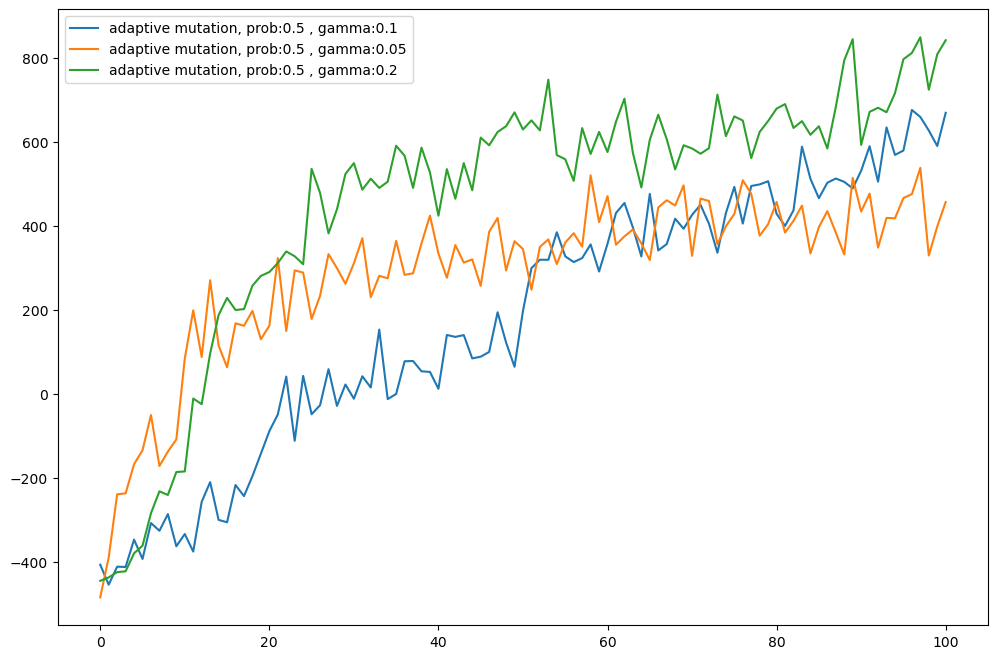

In [17]:
# import tikzplotlib
import matplotlib.pyplot as plt

repetitions = 3 #len(loaded_results[0])
no_of_experiments = len(loaded_results)
gens = np.arange(len(loaded_results[0][0]['fitness']))
plt.figure(figsize=(12, 8))
for exp in range(no_of_experiments):
    total_fitnesses = np.zeros(101)
    for rep in range(repetitions):
        total_fitnesses = total_fitnesses + loaded_results[exp][rep]['fitness']
    plt.plot(gens, total_fitnesses/repetitions, label=loaded_results[exp]['description'])

plt.legend()
# tikzplotlib.save('filename.tex')
plt.show()